In [4]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


kkt条件の完成(m=3)

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
#sysはコマンドライン引数
import sys
import csv
np.seterr(divide='ignore', invalid='ignore')
#csvファイルの読み込み、一行目はヘッダーじゃない
df = pd.read_csv("ransuu.csv",header=None)
#dfをnumpyで扱えるnp.ndarray変換
X = df.values
#配列の行数、列数の格納
X_size,dimension = X.shape
#クラスタ数宣言
c = 5
#Kはクラスタサイズ 
K = X_size /c
max_iter = 100
distances=np.zeros((X_size,c))
best_J = 10000

In [6]:
#uの最適化部分関数作成
def u_optimize(d):
    #変数定義
    u = [0] * len(d)
    for i in  range (len(d)):
        u[i] = cp.Variable()

    #目的関数定義
    Objective_function = 0 
    for i  in range(len(d)):
        Objective_function += d[i]*cp.power(u[i],3)
    objective = cp.Minimize(Objective_function)
    # 制約条件の定義
    zeroijou = []
    goukeiiti = []
    goukeigo = []
    constraints = []
    #0以上
    for i in range (len(d)):
        zeroijou.append(u[i]>=0)
    #合計1
    for i in range (0,len(d),c):
        #下の式はcの値によって逐次変更しないといけない
        goukeiiti.append(u[i]+u[i+1]+u[i+2]+u[i+3]+u[i+4]==1)
    #合計がクラスタサイズ
    #下の式はcの値によって逐次変更しないといけない
    goukeigo.append(sum(u[0:len(d):c])==K)
    goukeigo.append(sum(u[1:len(d):c])==K)
    goukeigo.append(sum(u[2:len(d):c])==K)
    goukeigo.append(sum(u[3:len(d):c])==K)
    goukeigo.append(sum(u[4:len(d):c])==K)
    constraints.extend(zeroijou)
    constraints.extend(goukeiiti)
    constraints.extend(goukeigo)
    
    # 問題を定義
    problem = cp.Problem(objective, constraints)
    # 最適化 (戻り値は最適化後に得られた値=最小値)
    result = problem.solve()
    #帰属度uと目的関数Jの値を抽出(ndarray型)
    u_value = np.empty(0)#空のndarrayを作成
    for i in range (len(d)):
        u_value = np.append(u_value,u[i].value)
    u = u_value
    return u,result

#クラスタ中心計算部分関数作成
def v_calculation(u_value):
    u_list = u_value.reshape([X_size,c])
    #分母計算(クラスタサイズになるはず)
    v0_denominator=0
    v1_denominator=0
    v2_denominator=0
    v3_denominator=0
    v4_denominator=0
    for i in range(0,len(d),c):
        v0_denominator += u_value[i]**3
    for i in range(1,len(d),c):
        v1_denominator += u_value[i]**3
    for i in range(2,len(d),c):
        v2_denominator += u_value[i]**3
    for i in range(3,len(d),c):
        v3_denominator += u_value[i]**3
    for i in range(4,len(d),c):
        v4_denominator += u_value[i]**3
    #分子計算
    v0_numerator = 0
    v1_numerator = 0
    v2_numerator = 0
    v3_numerator = 0
    v4_numerator = 0
    for i in range(X_size):
        v0_numerator += u_list[i][0]**3*X[i]
    for i in range(X_size):
        v1_numerator += u_list[i][1]**3*X[i]
    for i in range(X_size):
        v2_numerator += u_list[i][2]**3*X[i]
    for i in range(X_size):
        v3_numerator += u_list[i][3]**3*X[i]
    for i in range(X_size):
        v4_numerator += u_list[i][4]**3*X[i]
    v=[0 for i in range(5)]
    v[0] = v0_numerator / v0_denominator
    v[1] = v1_numerator / v1_denominator
    v[2] = v2_numerator / v2_denominator
    v[3] = v3_numerator / v3_denominator
    v[4] = v4_numerator / v4_denominator
    return v

for s in range (max_iter):
    centroids = X[np.random.choice(X_size,c)]
    #J = np.empty(0)
    for epoch in range(max_iter):
        #dにはd11,d12,d13,d14,d21,d22,,,dn1,,dncの順でリスト作る
        d=[]
        for i in range(X_size):
            for j in range(c):
                d.append(np.sum((X[i]-centroids[j])**2))
        #uの更新
        optimize_result = u_optimize(d)
        u = optimize_result[0]
        J = optimize_result[1]
        #vの更新
        v = v_calculation(u)
        new_centroids = np.array(v)
        new_centroids_kai = new_centroids[::-1,]
        # もしも重心が変わっていなかったら終了
        if (np.array_equal(new_centroids, centroids) or np.allclose(new_centroids_kai, centroids)):
            print("中心が変わらないのでbreakします！")
            break
        centroids =  np.copy(new_centroids)

    #目的関数が小さくなっている時、cluster,best_J,best_centoridsの更新を行う
    if best_J > J:
        u_list = u.reshape([X_size,c])
        np_cluster = np.argmax(u_list,axis=1)
        #最適な目的関数の更新
        best_J = J
        #目的関数が小さくなるときの重心を格納
        best_centroids = np.copy(new_centroids)
    print(s)
    print("回目のクラスタリング結果↓")
    print(best_J)
    print(best_centroids)
    print("終了")
print(np_cluster)
print(best_J)
print(best_centroids)

中心が変わらないのでbreakします！
0
回目のクラスタリング結果↓
0.5603847273551681
[[0.76665833 0.27443927]
 [0.28973085 0.32422467]
 [0.13667837 0.79326787]
 [0.84723115 0.74233628]
 [0.48314152 0.55016483]]
終了
中心が変わらないのでbreakします！
1
回目のクラスタリング結果↓
0.5603847273551681
[[0.76665833 0.27443927]
 [0.28973085 0.32422467]
 [0.13667837 0.79326787]
 [0.84723115 0.74233628]
 [0.48314152 0.55016483]]
終了
中心が変わらないのでbreakします！
2
回目のクラスタリング結果↓
0.5603847273551681
[[0.76665833 0.27443927]
 [0.28973085 0.32422467]
 [0.13667837 0.79326787]
 [0.84723115 0.74233628]
 [0.48314152 0.55016483]]
終了
中心が変わらないのでbreakします！
3
回目のクラスタリング結果↓
0.5603847273536765
[[0.84723119 0.74233642]
 [0.48313653 0.55017283]
 [0.13667675 0.79326613]
 [0.7666591  0.27444256]
 [0.28974034 0.32420832]]
終了
中心が変わらないのでbreakします！
4
回目のクラスタリング結果↓
0.5603847273535756
[[0.76665873 0.27443913]
 [0.1366784  0.79326793]
 [0.48314149 0.55016456]
 [0.84723086 0.74233641]
 [0.28973065 0.32422459]]
終了
中心が変わらないのでbreakします！
5
回目のクラスタリング結果↓
0.5603847273535756
[[0.76665873 0.27443913]


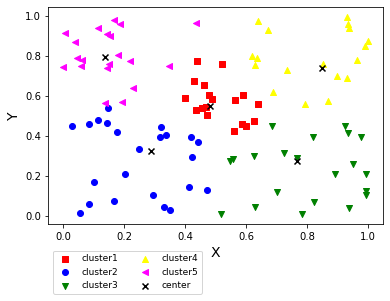

In [9]:
#グラフ
colors = ['red', 'blue', 'green','yellow','fuchsia']
markers = [",", "o", "v", "^", "<", ">", "1", "2", "3"]
fig = plt.figure()
ax = fig.add_subplot(111)
#clusterはnp.array型じゃないとダメそう(リスト型だとグラフに描画されなかった)
for i in range(c):
    ax.scatter(X[:, 0][np_cluster==i], X[:, 1][np_cluster==i], color=colors[i],marker=markers[i])
ax.scatter(best_centroids[:,0],best_centroids[:,1],color="black",marker="x")
#ax.set_title('fecbo', size=16)
ax.set_xlabel("X", size=14)
ax.set_ylabel("Y", size=14)
#ax.legend(['cluster1', 'cluster2','cluster3','cluster4','cluster5',"center"],fontsize=9)  # 凡例を表示
ax.legend(['cluster1', 'cluster2','cluster3','cluster4','cluster5',"center"],fontsize=9,ncol=2,bbox_to_anchor=(0, -0.1), loc='upper left')  # 凡例を表示

plt.show()

fig.savefig("ransuu_m3.pdf",bbox_inches='tight')

1を0\
0を1\
4を2\
3を4\
2を3

In [11]:
cluster_hensyuu = np_cluster
cluster_hensyuu_0 = np.where(cluster_hensyuu==4, 100, np_cluster)
cluster_hensyuu_1 = np.where(cluster_hensyuu_0==3, 4, cluster_hensyuu_0)
cluster_hensyuu_2 = np.where(cluster_hensyuu_1==2, 3, cluster_hensyuu_1)
cluster_hensyuu_3 = np.where(cluster_hensyuu_2==100, 2, cluster_hensyuu_2)
hensyuu = np.where(cluster_hensyuu_3==0, 100, cluster_hensyuu_3)
hensyuu1 = np.where(hensyuu==1, 0, hensyuu)
hensyuu3 = np.where(hensyuu1==100, 1, hensyuu1)

In [8]:
print(np.count_nonzero(np_cluster==0))
print(np.count_nonzero(np_cluster==1))
print(np.count_nonzero(np_cluster==2))
print(np.count_nonzero(np_cluster==3))
print(np.count_nonzero(np_cluster==4))

18
23
21
18
20


In [347]:
print("帰属度とクラスタサイズの確認")
print(np.sum(u_list, axis=1))#行ごとの合計値1になるはず
print(np.sum(u_list, axis=0))#列ごとの合計値Kになるはず

帰属度とクラスタサイズの確認
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]
[20. 20. 20. 20. 20.]


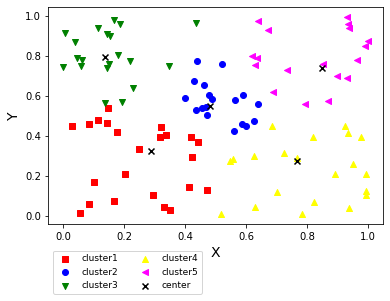

In [13]:
#グラフ
colors = ['red', 'blue', 'green','yellow','fuchsia']
markers = [",", "o", "v", "^", "<", ">", "1", "2", "3"]
fig = plt.figure()
ax = fig.add_subplot(111)
#clusterはnp.array型じゃないとダメそう(リスト型だとグラフに描画されなかった)
for i in range(c):
    ax.scatter(X[:, 0][hensyuu3==i], X[:, 1][hensyuu3==i], color=colors[i],marker=markers[i])

ax.scatter(best_centroids[:,0],best_centroids[:,1],color="black",marker="x")
#ax.set_title('fecbo', size=16)
ax.set_xlabel("X", size=14)
ax.set_ylabel("Y", size=14)
ax.legend(['cluster1', 'cluster2','cluster3','cluster4','cluster5',"center"],fontsize=9,ncol=2,bbox_to_anchor=(0, -0.1), loc='upper left')  # 凡例を表示

plt.show()

fig.savefig("ransuu_m3.pdf",bbox_inches='tight')

### ここまでが完成コード

In [14]:
print(np.count_nonzero(hensyuu3==0))
print(np.count_nonzero(hensyuu3==1))
print(np.count_nonzero(hensyuu3==2))
print(np.count_nonzero(hensyuu3==3))
print(np.count_nonzero(hensyuu3==4))

23
18
20
21
18


In [331]:
u_list

array([[2.80887542e-02, 3.38961295e-02, 8.51168654e-02, 3.89895755e-02,
        8.13908675e-01],
       [2.24827092e-03, 1.57081983e-02, 5.53600901e-02, 9.07081342e-01,
        1.96020987e-02],
       [8.74175158e-01, 2.17389576e-02, 5.76850510e-02, 1.78551666e-02,
        2.85456669e-02],
       [2.20306210e-02, 8.69565910e-01, 4.21344006e-02, 2.95332292e-02,
        3.67358388e-02],
       [9.11278965e-09, 1.04713998e-08, 9.99999959e-01, 1.14584518e-08,
        1.01136167e-08],
       [6.00075476e-02, 7.26335140e-02, 9.44198090e-02, 7.76956440e-02,
        6.95243485e-01],
       [3.68628832e-02, 4.56450490e-02, 8.28108920e-02, 4.96334363e-02,
        7.85047739e-01],
       [9.02618890e-02, 7.71389287e-02, 1.30797479e-01, 8.45005731e-02,
        6.17301130e-01],
       [6.97410296e-02, 6.67735606e-02, 1.00992795e-01, 6.59332712e-02,
        6.96559344e-01],
       [6.26020995e-02, 7.60603378e-02, 9.59016427e-02, 8.11986465e-02,
        6.84237273e-01],
       [1.53407570e-02, 2.5804

In [276]:
print(np.count_nonzero(np_cluster==0))
print(np.count_nonzero(np_cluster==1))
print(np.count_nonzero(np_cluster==2))
print(np.count_nonzero(np_cluster==3))
print(np.count_nonzero(np_cluster==4))

21
21
15
21
21


In [247]:
#作業用セル(使用中)(制約条件変更中)（12/13）
centroids = X[np.random.choice(X_size,c)]
#dにはd11,d12,d13,d14,d21,d22,,,dn1,,dncの順でリスト作る
d=[]
for i in range(X_size):
    for j in range(c):
        d.append(np.sum((X[i]-centroids[j])**2))
#uの最適化
u = [0] * len(d)
#変数定義
for i in  range (len(d)):
    u[i] = cp.Variable()
#目的関数定義
Objective_function = 0 
for i  in range(len(d)):
    Objective_function += d[i]*cp.power(u[i],3)
objective = cp.Minimize(Objective_function)
# 制約条件の定義
zeroijou = []
goukeiiti = []
goukeigo = []
constraints = []
#0以上
for i in range (len(d)):
    zeroijou.append(u[i]>=0)
#合計1
for i in range (0,len(d),c):
    #下の式はcの値によって逐次変更しないといけない
    goukeiiti.append(u[i]+u[i+1]+u[i+2]+u[i+3]+u[i+4]==1)
#合計がクラスタサイズ
#下の式はcの値によって逐次変更しないといけない
goukeigo.append(sum(u[0:len(d):c])==K)
goukeigo.append(sum(u[1:len(d):c])==K)
goukeigo.append(sum(u[2:len(d):c])==K)
goukeigo.append(sum(u[3:len(d):c])==K)
goukeigo.append(sum(u[4:len(d):c])==K)
constraints.extend(zeroijou)
constraints.extend(goukeiiti)
constraints.extend(goukeigo)

# 問題を定義
problem = cp.Problem(objective, constraints)
# 最適化 (戻り値は最適化後に得られた値=最小値)
result = problem.solve()

#帰属度uと目的関数Jの値を抽出(ndarray型)
u_value = np.empty(0)#空のndarrayを作成
for i in range (len(d)):
    u_value = np.append(u_value,u[i].value)

u_list = u_value.reshape([99,5])

print("帰属度とクラスタサイズの確認")
print(np.sum(u_list, axis=1))#行ごとの合計値1になるはず
print(np.sum(u_list, axis=0))#列ごとの合計値Kになるはず

帰属度とクラスタサイズの確認
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1.]
[19.8 19.8 19.8 19.8 19.8]


In [249]:
#クラスタ中心計算部分関数作成
def v_calculation(u_vallue):
    u_list = u_value.reshape([99,5])
    #分母計算(クラスタサイズになるはず)
    v0_denominator=0
    v1_denominator=0
    v2_denominator=0
    v3_denominator=0
    v4_denominator=0
    for i in range(0,len(d),c):
        v0_denominator += u_value[i]**3
    for i in range(1,len(d),c):
        v1_denominator += u_value[i]**3
    for i in range(2,len(d),c):
        v2_denominator += u_value[i]**3
    for i in range(3,len(d),c):
        v3_denominator += u_value[i]**3
    for i in range(4,len(d),c):
        v4_denominator += u_value[i]**3
    #分子計算
    v0_numerator = 0
    v1_numerator = 0
    v2_numerator = 0
    v3_numerator = 0
    v4_numerator = 0
    for i in range(X_size):
        v0_numerator += u_list[i][0]**3*X[i]
    for i in range(X_size):
        v1_numerator += u_list[i][1]**3*X[i]
    for i in range(X_size):
        v2_numerator += u_list[i][2]**3*X[i]
    for i in range(X_size):
        v3_numerator += u_list[i][3]**3*X[i]
    for i in range(X_size):
        v4_numerator += u_list[i][4]**3*X[i]
    v=[0 for i in range(5)]
    v[0] = v0_numerator / v0_denominator
    v[1] = v1_numerator / v1_denominator
    v[2] = v2_numerator / v2_denominator
    v[3] = v3_numerator / v3_denominator
    v[4] = v4_numerator / v4_denominator
    return v

In [250]:
#uの最適化部分関数作成
def u_optimize(d,J):
    #変数定義
    u = [0] * len(d)
    for i in  range (len(d)):
        u[i] = cp.Variable()

    #目的関数定義
    Objective_function = 0 
    for i  in range(len(d)):
        Objective_function += d[i]*cp.power(u[i],3)
    objective = cp.Minimize(Objective_function)
    # 制約条件の定義
    zeroijou = []
    goukeiiti = []
    goukeigo = []
    constraints = []
    #0以上
    for i in range (len(d)):
        zeroijou.append(u[i]>=0)
    #合計1
    for i in range (0,len(d),c):
        #下の式はcの値によって逐次変更しないといけない
        goukeiiti.append(u[i]+u[i+1]+u[i+2]+u[i+3]+u[i+4]==1)
    #合計がクラスタサイズ
    #下の式はcの値によって逐次変更しないといけない
    goukeigo.append(sum(u[0:len(d):c])==K)
    goukeigo.append(sum(u[1:len(d):c])==K)
    goukeigo.append(sum(u[2:len(d):c])==K)
    goukeigo.append(sum(u[3:len(d):c])==K)
    goukeigo.append(sum(u[4:len(d):c])==K)
    constraints.extend(zeroijou)
    constraints.extend(goukeiiti)
    constraints.extend(goukeigo)
    
    # 問題を定義
    problem = cp.Problem(objective, constraints)
    # 最適化 (戻り値は最適化後に得られた値=最小値)
    result = problem.solve()
    #帰属度uと目的関数Jの値を抽出(ndarray型)
    u_value = np.empty(0)#空のndarrayを作成
    for i in range (len(d)):
        u_value = np.append(u_value,u[i].value)
    u = u_value
    J = np.append(J,result)
    return u,J
#クラスタ中心計算部分関数作成
#クラスタ中心計算部分関数作成
def v_calculation(u_value):
    u_list = u_value.reshape([99,5])
    #分母計算(クラスタサイズになるはず)
    v0_denominator=0
    v1_denominator=0
    v2_denominator=0
    v3_denominator=0
    v4_denominator=0
    for i in range(0,len(d),c):
        v0_denominator += u_value[i]**3
    for i in range(1,len(d),c):
        v1_denominator += u_value[i]**3
    for i in range(2,len(d),c):
        v2_denominator += u_value[i]**3
    for i in range(3,len(d),c):
        v3_denominator += u_value[i]**3
    for i in range(4,len(d),c):
        v4_denominator += u_value[i]**3
    #分子計算
    v0_numerator = 0
    v1_numerator = 0
    v2_numerator = 0
    v3_numerator = 0
    v4_numerator = 0
    for i in range(X_size):
        v0_numerator += u_list[i][0]**3*X[i]
    for i in range(X_size):
        v1_numerator += u_list[i][1]**3*X[i]
    for i in range(X_size):
        v2_numerator += u_list[i][2]**3*X[i]
    for i in range(X_size):
        v3_numerator += u_list[i][3]**3*X[i]
    for i in range(X_size):
        v4_numerator += u_list[i][4]**3*X[i]
    v=[0 for i in range(5)]
    v[0] = v0_numerator / v0_denominator
    v[1] = v1_numerator / v1_denominator
    v[2] = v2_numerator / v2_denominator
    v[3] = v3_numerator / v3_denominator
    v[4] = v4_numerator / v4_denominator
    return v

In [217]:
v

[array([0.49631367, 0.32719417]),
 array([0.54659171, 0.51736084]),
 array([0.50266058, 0.32294809]),
 array([0.50835673, 0.68137432]),
 array([0.49897542, 0.51704361])]